# MITCH data loader

Data exchange between MITCH and PC is done via a costum software of 221e. The data is stored in a .txt file with a timestamp in EPOCH format as first column. The other columns contain the data of the different integrated sensors. In the software you can choose the directory to put the file in. 

Here we load the data from the file, convert to appropriate units and plot the single data columns in order to execute a first check of data quality and the functionality of the MITCH Bootsensing platform.

In [1]:
# Import packages
import sys
import pandas as pd
import time
import numpy as np
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt # for plots
import matplotlib.patches as mpatches # plot legend for multiple signals in one plot
import matplotlib.dates as md
from matplotlib.dates import DateFormatter
import math # maths package
import pylab
%matplotlib notebook
from matplotlib.pyplot import figure
#import scipy.signal
import scipy.signal as signal
import statistics as stat
import cufflinks as cf
from IPython.display import display,HTML
import scipy.fftpack

In [3]:
# Load data from .txt file in DataFrame
#11.12.2020: 153030, 173934 (Axamer Kögele: Uphill&Downhill -> 1.170Hm, quite steep, off-piste with some jumps)
#14.12.2020: 171534, 182555(Birgitzköpfl: Uphill&Downhill -> 600Hm, flat and normal sections, old piste, some jumps)
#15.12.2020: 171802, 182518, 183349, 185601, 190328, 192649(Birgitzköpfl + 2x BA-BK)
#17.12.2020: 173106, 182308(Rauthhütte)
#27.12.2020: 131048, 133101 (Kuhleiten down)
#DX 13.01.2021: 165241 (Kuhleiten up), 183219 (Kuhleiten down)
#SX 13.01.2021: 165315 (Kuhleiten up), 183301 (Kuhleiten down)
#MTB 08.01.2021: 100418
date = "13.01.2021" # insert date in format dd.mm.yyyy e.g. 17.11.2020
time = "165241" # hhmmss insert time e.g. 180903
fileformat = ".txt" # fileformat for default .txt
filename = date + ' '+ time + fileformat # create filename
df_import=pd.DataFrame()
df_import= pd.read_csv(filename,delimiter='\t',skiprows=9) # delimiter '\t' for blank


In [4]:
# Convert Timestamp from EPOCH format to CET and change column names of dataframe

timecol=df_import.iloc[:,0]/1000 # divide by 1000 to get format which is convertable with ms 

time_conv={}
time_conv_CET={}
for i in range(len(timecol)):
    time_conv[i]=datetime.fromtimestamp(timecol.loc[i]).strftime('%Y-%m-%d %H:%M:%S.%f')
    #time_conv_CET[i]=(time_conv[i]+timedelta(hours=1)).strftime('%Y-%m-%d %H:%M:%S.%f')# convert to CET, to get ms use datetime.fromtimestamp().strftime()

df_t = pd.DataFrame(time_conv,index=[0]).transpose() # pass time col in CET format in DataFrame
df = pd.concat([df_t, df_import.iloc[:,1:]], axis=1) # dataframe with Timestamp in CET format
col_names=['t','Acc.X','Acc.Y','Acc.Z','Gyro.X','Gyro.Y','Gyro.Z','Magn.X','Magn.Y','Magn.Z','1A','1B','2A','2B','3A','3B','4A','4B','Temp'] # new columns names
df.columns=col_names # rename columns of dataframe

print(max(df['1A']),max(df['1B']),max(df['2A']),max(df['2B']),max(df['3A']),max(df['3B']),max(df['4A']),max(df['4B']))
print(min(df['1A']),min(df['1B']),min(df['2A']),min(df['2B']),min(df['3A']),min(df['3B']),min(df['4A']),min(df['4B']))


254 134 254 254 254 134 131 126
249 121 252 252 124 118 103 117


# Histogram

<IPython.core.display.Javascript object>


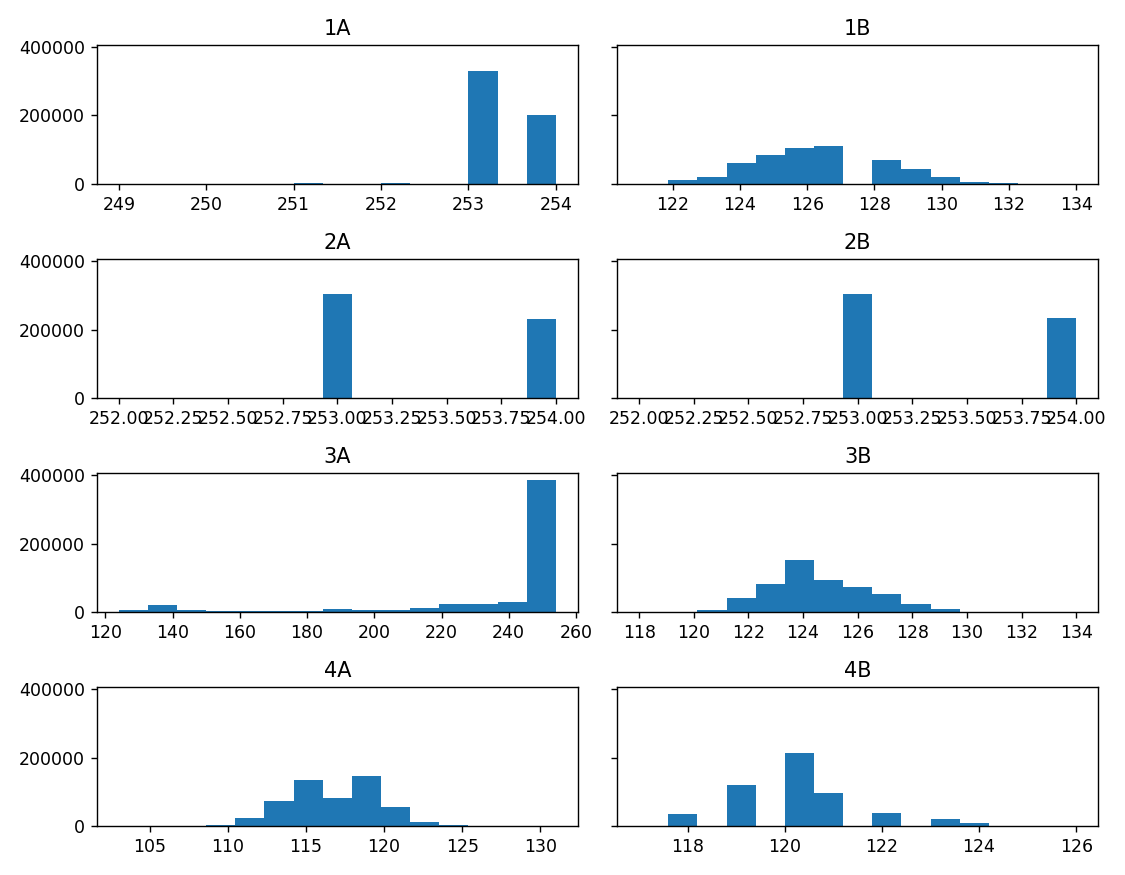

In [5]:
# Histogram of strain gauges 1-4 A & B
fig0, axs0 = plt.subplots(4, 2, sharey=True, tight_layout=True,figsize=(9, 7))
axs0[0,0].hist(df['1A'], bins=15)
axs0[0,0].set_title('1A')
axs0[0,1].hist(df['1B'], bins=15)
axs0[0,1].set_title('1B')
axs0[1,0].hist(df['2A'], bins=15)
axs0[1,0].set_title('2A')
axs0[1,1].hist(df['2B'], bins=15)
axs0[1,1].set_title('2B')
axs0[2,0].hist(df['3A'], bins=15)
axs0[2,0].set_title('3A')
axs0[2,1].hist(df['3B'], bins=15)
axs0[2,1].set_title('3B')
axs0[3,0].hist(df['4A'], bins=15)
axs0[3,0].set_title('4A')
axs0[3,1].hist(df['4B'], bins=15)
axs0[3,1].set_title('4B')
plt.show()

# Baseline calculation

At the beginning and at the end of every registration the athlete has to stand still for 10s to acquire a baseline. Below the respective 1000 rows will be extracted and a mean of them is calculated.

In [6]:
base_start =  df[['1A','1B','2A','2B','3A','3B','4A','4B']].iloc[1:1000].mean()
base_end = df[['1A','1B','2A','2B','3A','3B','4A','4B']].iloc[(len(df)-1000):].mean()
base_diff = base_start - base_end
print(base_start,base_end)
# Convert strain gauge base value to the real resistance value to compare with nominal values of 
R_0 = 350 # nominal resistance R_0 = 350 Ohm
G = 49.8 # gain
N0 = 255 # 8-bit ADC (0-255 = 256 values)
#R_base_start = pd.DataFrame() 
#R_base_end = pd.DataFrame() 
R_base_start = {}
R_base_end = {}

for i in range(len(base_start)):
    R_base_start[i] = R_0*((0.5+((base_start.iloc[i]-(N0/2))/(N0*G)))/(1-(0.5+(base_start.iloc[i]-(N0/2))/(N0*G))))
    R_base_end[i] = R_0*((0.5+((base_end.iloc[i]-(N0/2))/(N0*G)))/(1-(0.5+(base_end.iloc[i]-(N0/2))/(N0*G))))
#print(pd.Series(R_base_start))
#print(pd.Series(R_base_end))


1A    253.275275
1B    130.749750
2A    253.380380
2B    253.365365
3A    201.309309
3B    128.474474
4A    126.892893
4B    122.908909
dtype: float64 1A    253.443
1B    124.038
2A    253.515
2B    253.523
3A    253.583
3B    123.973
4A    115.238
4B    118.136
dtype: float64


# Plot raw strain gauge data

In [8]:
# Plots for raw strain gauge values
fig1, ax1 = plt.subplots(4,1, figsize=(12, 10), sharex='col')
fig1.suptitle('Raw values', fontsize=16)
ax1[0].plot(df['t'],df['1A'],'b',df['t'],df['1B'],'r')
#ax1[0].set(xlabel='datetime')
ax1[0].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[0].set(ylabel='raw value strain gauge')
ax1[0].set_title('Strain gauge 1')
ax1[0].legend(['1A','1B'])
ax1[1].plot(df['t'],df['2A'],'b',df['t'],df['2B'],'r')
#ax1[1].set(xlabel='datetime')
ax1[1].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[1].set(ylabel='raw value strain gauge')
ax1[1].set_title('Strain gauge 2')
ax1[1].legend(['2A','2B'])
ax1[2].plot(df['t'],df['3A'],'b',df['t'],df['3B'],'r')
#ax1[2].set(xlabel='datetime')
ax1[2].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[2].set(ylabel='raw value strain gauge')
ax1[2].set_title('Strain gauge 3')
ax1[2].legend(['3A','3B'])
ax1[3].plot(df['t'],df['4A'],'b',df['t'],df['4B'],'r')
ax1[3].set(xlabel='datetime')
ax1[3].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[3].set(ylabel='raw value strain gauge')
ax1[3].set_title('Strain gauge 4')
ax1[3].legend(['4A','4B'])
#plt.plot(df['Timestamp'],df['1A'],'b',df['Timestamp'],df['1B'],'r')
#plt.plot(df['t'][200:300],df['4B'][200:300],'r',df['t'][200:300],df['4A'][200:300],'b')
plt.show()


<IPython.core.display.Javascript object>

# Smoothing signal

Using a Savitzky–Golay filter

In [7]:
#sos = signal.butter(10, 15, 'hp', fs=1000, output='sos')
#filtered = signal.sosfilt(sos, df['1A'])
df_filt=pd.DataFrame()
df_filt['1A'] = scipy.signal.savgol_filter(df['1A'], 51, 3)
df_filt['1B'] = scipy.signal.savgol_filter(df['1B'], 51, 3)
df_filt['2A'] = scipy.signal.savgol_filter(df['2A'], 51, 3)
df_filt['2B'] = scipy.signal.savgol_filter(df['2B'], 51, 3)
df_filt['3A'] = scipy.signal.savgol_filter(df['3A'], 51, 3)
df_filt['3B'] = scipy.signal.savgol_filter(df['3B'], 51, 3)
df_filt['4A'] = scipy.signal.savgol_filter(df['4A'], 51, 3)
df_filt['4B'] = scipy.signal.savgol_filter(df['4B'], 51, 3)
df_new=pd.concat([df_t, df_filt['1A'],df_filt['1B'],df_filt['2A'],df_filt['2B'],df_filt['3A'],df_filt['3B'],df_filt['4A'],df_filt['4B']], axis=1)
col_names=['t','1A','1B','2A','2B','3A','3B','4A','4B']

df_new.columns=col_names
# Plots for raw strain gauge values
fig2, ax2 = plt.subplots(2,1, figsize=(12, 10), sharex='col')
fig2.suptitle('Raw values', fontsize=16)
ax2[0].plot(df['t'],df_filt['3A'],'b',df['t'],df_filt['3B'],'r')
ax2[0].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax2[0].set(ylabel='raw value strain gauge')
ax2[0].set_title('Strain gauge 3')
ax2[0].legend(['3A','3B'])
ax2[1].plot(df['t'],df_filt['4A'],'b',df['t'],df_filt['4B'],'r')
ax2[1].set(xlabel='datetime')
ax2[1].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax2[1].set(ylabel='raw value strain gauge')
ax2[1].set_title('Strain gauge 4')
ax2[1].legend(['4A','4B'])
#plt.plot(df['Timestamp'],df['1A'],'b',df['Timestamp'],df['1B'],'r')
#plt.plot(df['t'][200:300],df['4B'][200:300],'r',df['t'][200:300],df['4A'][200:300],'b')
plt.show()



KeyError: '1A'

# Convert strain gauge data

In [9]:
# Convert strain gauge value N to the real resistance value Rx
R_0 = 350 # nominal resistance R_0 = 350 Ohm -> replace with respective base start value
G = 49.8 # gain
N0 = 255 # 8-bit ADC (0-255 = 256 values)
N = df[['1A','1B','2A','2B','3A','3B','4A','4B']][35000:36000] # test col 1A for N
Rx = pd.DataFrame() # initalize empty DataFrame for real resistance values

# Loop in to fill Rx DataFrame
for i in range(len(N)):
    for j in range(len(N.columns)):
        Rx.loc[i,j] = R_0*((0.5+((N.iloc[i,j]-(N0/2))/(N0*G)))/(1-(0.5+(N.iloc[i,j]-(N0/2))/(N0*G))))
Rx.columns = ['1A','1B','2A','2B','3A','3B','4A','4B'] # rename columns of Rx 

# Calculation of strain eps in [%] -> max. elongation/compression of strain gauge +/-3%
eps = pd.DataFrame() # initalize empty DataFrame for epsilon

for i in range(len(Rx)):
    for j in range(len(Rx.columns)):
        eps.loc[i,j] = (abs(R_0-Rx.iloc[i,j]))/R_0
eps.columns = ['1A','1B','2A','2B','3A','3B','4A','4B'] # rename columns of eps
print(eps)
print(max(eps['1A']),max(eps['1B']),max(eps['2A']),max(eps['2B']),max(eps['3A']),max(eps['3B']),max(eps['4A']),max(eps['4B']))

ValueError: Length mismatch: Expected axis has 0 elements, new values have 8 elements

# Plot resistance values

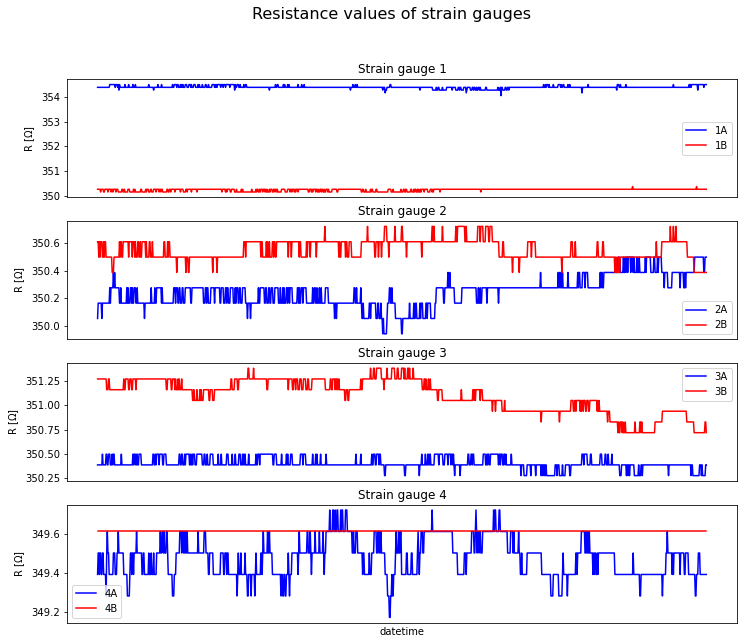

In [42]:
# Plots for resistance values strain gauge 
fig1, ax1 = plt.subplots(4,1, figsize=(12, 10), sharex='col')
fig1.suptitle('Resistance values of strain gauges', fontsize=16)
ax1[0].plot(df['t'][35000:36000],Rx['1A'],'b',df['t'][35000:36000],Rx['1B'],'r')
#ax1[0].set(xlabel='datetime')
ax1[0].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[0].set(ylabel='R $[\Omega]$')
ax1[0].set_title('Strain gauge 1')
ax1[0].legend(['1A','1B'])
ax1[1].plot(df['t'][35000:36000],Rx['2A'],'b',df['t'][35000:36000],Rx['2B'],'r')
#ax1[1].set(xlabel='datetime')
ax1[1].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[1].set(ylabel='R $[\Omega]$')
ax1[1].set_title('Strain gauge 2')
ax1[1].legend(['2A','2B'])
ax1[2].plot(df['t'][35000:36000],Rx['3A'],'b',df['t'][35000:36000],Rx['3B'],'r')
#ax1[2].set(xlabel='datetime')
ax1[2].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[2].set(ylabel='R $[\Omega]$')
ax1[2].set_title('Strain gauge 3')
ax1[2].legend(['3A','3B'])
ax1[3].plot(df['t'][35000:36000],Rx['4A'],'b',df['t'][35000:36000],Rx['4B'],'r')
ax1[3].set(xlabel='datetime')
ax1[3].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[3].set(ylabel='R $[\Omega]$')
ax1[3].set_title('Strain gauge 4')
ax1[3].legend(['4A','4B'])
#plt.plot(df['Timestamp'],df['1A'],'b',df['Timestamp'],df['1B'],'r')
#plt.plot(df['t'][200:300],df['4B'][200:300],'r',df['t'][200:300],df['4A'][200:300],'b')
plt.show()

# Plot strain values

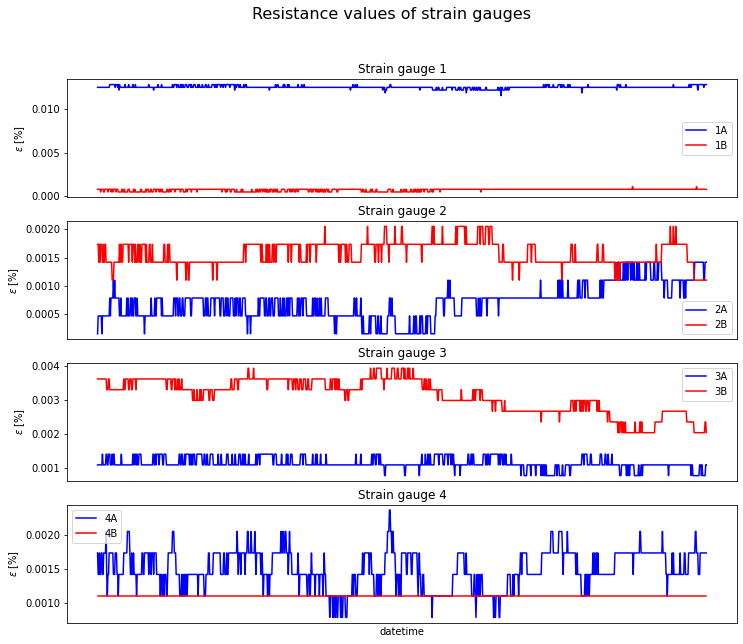

In [44]:
# Plots for strain values strain gauge 
fig1, ax1 = plt.subplots(4,1, figsize=(12, 10), sharex='col')
fig1.suptitle('Resistance values of strain gauges', fontsize=16)
ax1[0].plot(df['t'][35000:36000],eps['1A'],'b',df['t'][35000:36000],eps['1B'],'r')
#ax1[0].set(xlabel='datetime')
ax1[0].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[0].set(ylabel='$\epsilon$ [%]')
ax1[0].set_title('Strain gauge 1')
ax1[0].legend(['1A','1B'])
ax1[1].plot(df['t'][35000:36000],eps['2A'],'b',df['t'][35000:36000],eps['2B'],'r')
#ax1[1].set(xlabel='datetime')
ax1[1].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[1].set(ylabel='$\epsilon$ [%]')
ax1[1].set_title('Strain gauge 2')
ax1[1].legend(['2A','2B'])
ax1[2].plot(df['t'][35000:36000],eps['3A'],'b',df['t'][35000:36000],eps['3B'],'r')
#ax1[2].set(xlabel='datetime')
ax1[2].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[2].set(ylabel='$\epsilon$ [%]')
ax1[2].set_title('Strain gauge 3')
ax1[2].legend(['3A','3B'])
ax1[3].plot(df['t'][35000:36000],eps['4A'],'b',df['t'][35000:36000],eps['4B'],'r')
ax1[3].set(xlabel='datetime')
ax1[3].tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
ax1[3].set(ylabel='$\epsilon$ [%]')
ax1[3].set_title('Strain gauge 4')
ax1[3].legend(['4A','4B'])
#plt.plot(df['Timestamp'],df['1A'],'b',df['Timestamp'],df['1B'],'r')
#plt.plot(df['t'][200:300],df['4B'][200:300],'r',df['t'][200:300],df['4A'][200:300],'b')
plt.show()

# Gyroscope data

<IPython.core.display.Javascript object>


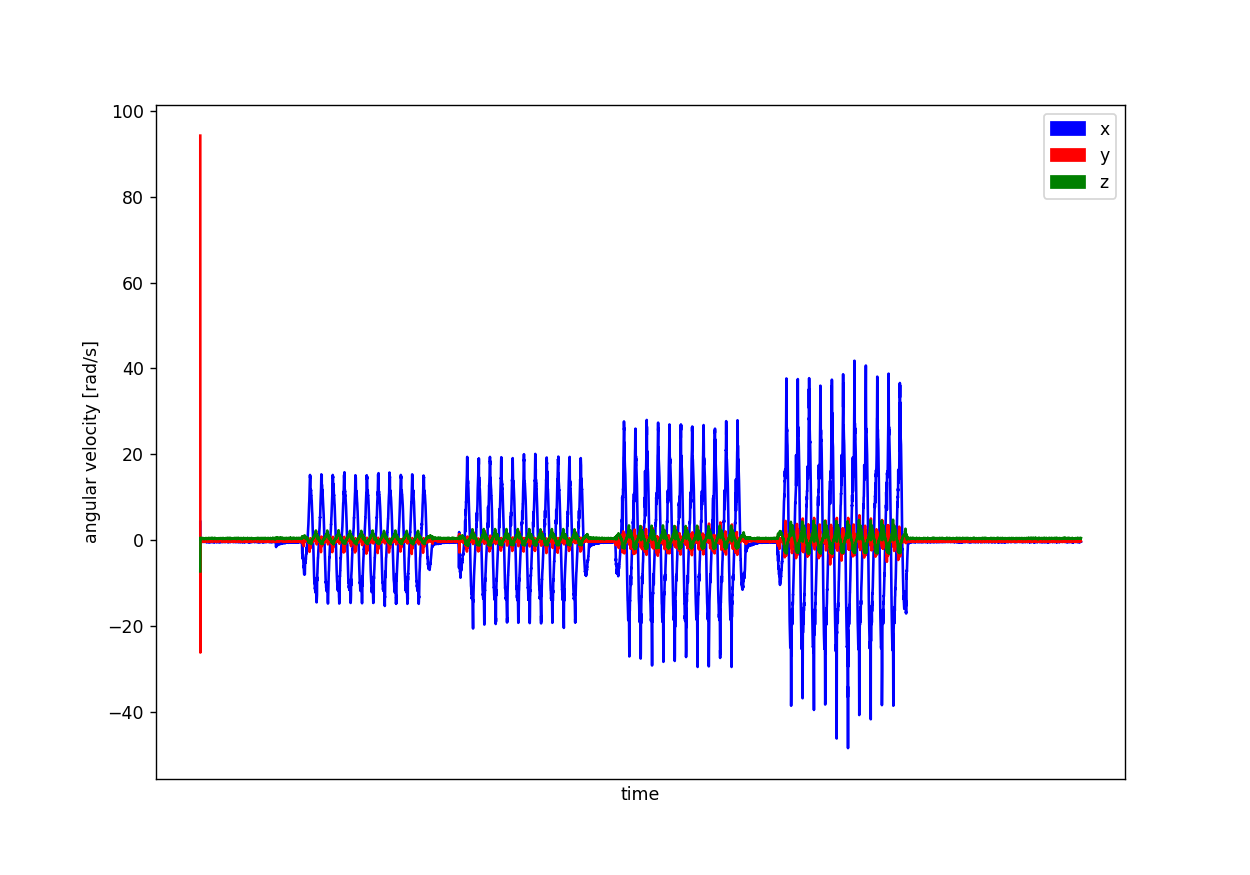

<ipython-input-20-2880e802bff3>:22: UserWarning: 'set_params()' not defined for locator of type <class 'matplotlib.category.StrCategoryLocator'>
  plt.locator_params(axis='x', nbins=10)


In [20]:
# Convert Gyroscope data from dps to rad/s (SI Unit)

plt.figure(figsize=(10, 7))
plt.plot(df['t'],df['Gyro.X'],'b',df['t'],df['Gyro.Y'],'r',df['t'],df['Gyro.Z'],'g')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.xlabel('time')
plt.ylabel('angular velocity [rad/s]')
blue_patch = mpatches.Patch(color='blue', label='x')
red_patch = mpatches.Patch(color='red', label='y')
green_patch = mpatches.Patch(color='green', label='z')
plt.legend(handles=[blue_patch,red_patch,green_patch])
#plt.locator_params(axis='x', nbins=10)
plt.xticks(rotation=45)
plt.show()

# Accelerometer data

In [ ]:
# Plot x,y,z data of Accelerometer in one plot
# 1 g = 9,81 m/s^2
plt.figure(figsize=(12, 7))

plt.plot(df['t'],df['Acc.X'],'b',df['t'],df['Acc.Y'],'r',df['t'],df['Acc.Z'],'g')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
plt.xlabel('time')
plt.ylabel('acceleration [m/s^2]')
blue_patch = mpatches.Patch(color='blue', label='x')
red_patch = mpatches.Patch(color='red', label='y')
green_patch = mpatches.Patch(color='green', label='z')
plt.legend(handles=[blue_patch,red_patch,green_patch])
#plt.locator_params(axis='x', nbins=10)
plt.xticks(rotation=45)
plt.show()

<IPython.core.display.Javascript object>

# Temperature

<IPython.core.display.Javascript object>


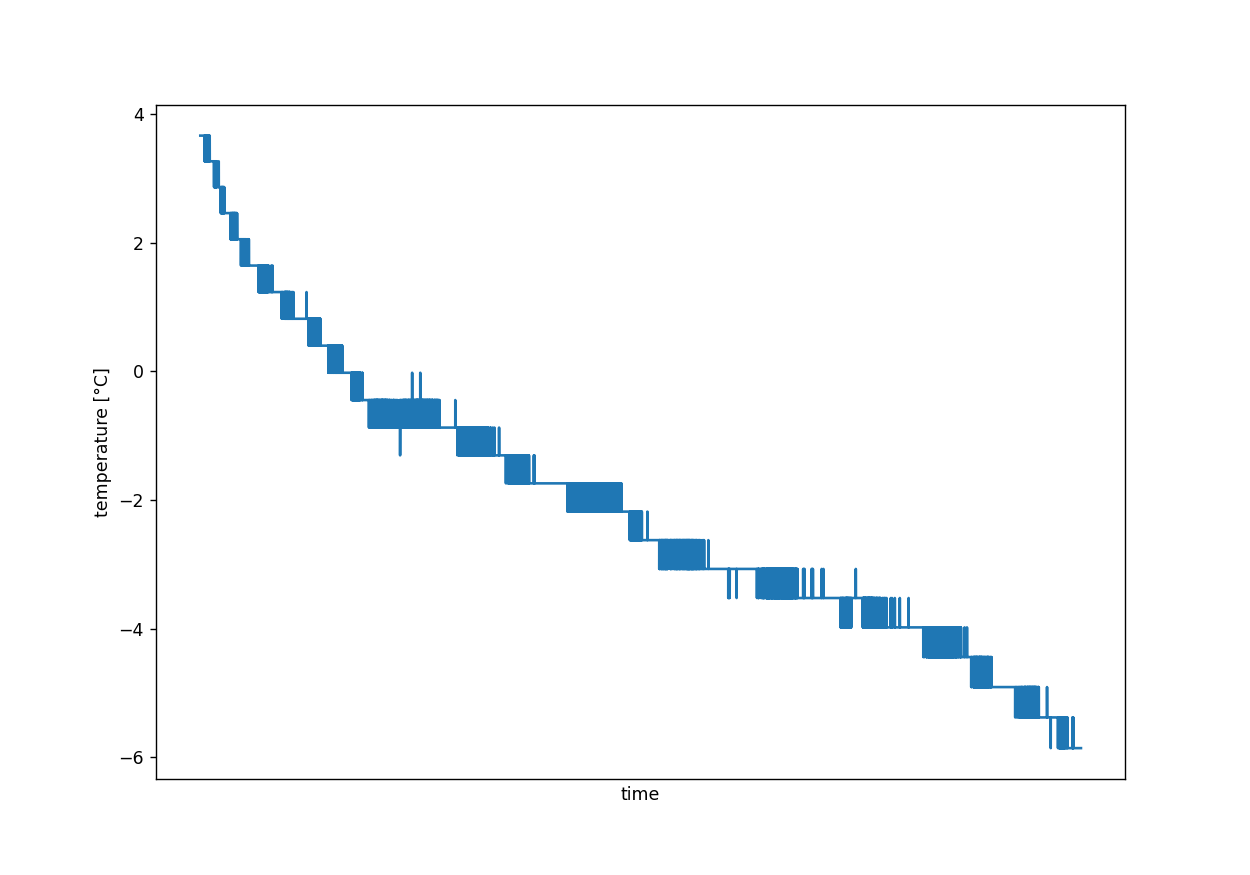

In [16]:
# Plot of temperature curve
plt.figure(figsize=(10, 7))
plt.plot(df['t'],df['Temp'])
#ax = fig.gca()
#fig.autofmt_xdate()
#ax.fmt_xdata = mdates.DateFormatter('%Y-%m-%d')
#xfmt = md.DateFormatter('%Y-%m-%d %H:%M:%S')
#ax.xaxis.set_major_formatter(xfmt)
plt.xlabel('time')
plt.ylabel('temperature [°C]')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)
#ax.locator_params(nbins=4)
#plt.gcf().autofmt_xdate()
plt.xticks(ticks=None)
#date_form = DateFormatter("%m-%d")
#plt.xaxis.set_major_formatter(date_form)
plt.show()